In [120]:
import psi4
import numpy as np
import matplotlib.pyplot as plt

In [121]:
# Set Psi4 memory
psi4.set_memory("4 GiB")


  Memory set to   4.000 GiB by Python driver.


4294967296

In [122]:
# Geometry specification
mol = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
symmetry c1
""")
# mol = psi4.geometry("""
# C         -1.00159        3.37758        0.00000
# O          0.07437        3.90210        0.00000
# O         -2.07755        2.85305        0.00000
# symmetry c1
# """)

basis = "pcseg-1"

# Psi4 options
psi4.set_options(
    {
        "basis": basis,
        "scf_type": "df",
        "e_convergence": 1e-10,
        "d_convergence": 1e-10,
        "guess": "SAD",
    }
)

wfn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option("basis"))

guess_wfn = psi4.driver.scf_wavefunction_factory(
    name="hf", ref_wfn=wfn, reference="RHF"
)
guess_wfn.form_H()
guess_wfn.form_Shalf()
guess_wfn.guess()
D_guess = guess_wfn.Da()

scf_e, scf_wfn = psi4.energy("scf", return_wfn=True)
D_pq = scf_wfn.Da()



   => Loading Basis Set <=

    Name: PCSEG-1
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry O          line   132 file /home/etschgi1/miniconda3/envs/scf_dev/share/psi4/basis/pcseg-1.gbs 
    atoms 2-3 entry H          line    13 file /home/etschgi1/miniconda3/envs/scf_dev/share/psi4/basis/pcseg-1.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,   4096 MiB Core
         ---------------------------------------------------------

  ==> Geometry <==

    Molecular point group: c1
    Full point group: C2v

    Geometry (in Angstrom), charge = 0, multiplicity = 1:

       Center              X                  Y                   Z               Mass       
    ------------   -----------------  -----------------  -----------------

In [123]:
# dump psi4 densities & energy to compare
import pickle
with open("data/psi4_density.pkl", "wb") as f:
    pickle.dump(scf_e, f)
    pickle.dump(np.array(D_pq), f)
    pickle.dump(np.array(D_guess), f)   

Text(0.5, 1.0, 'Converged density')

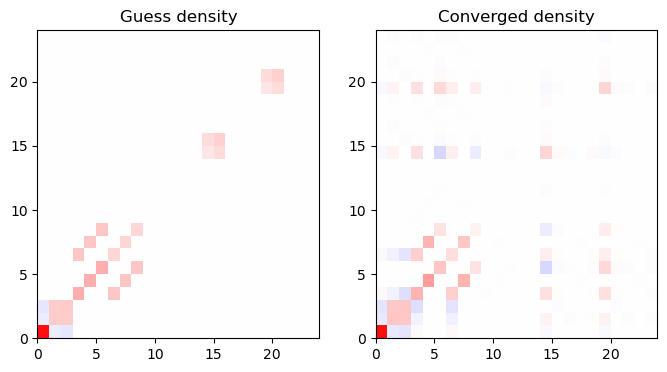

In [124]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=2)

ax[0].pcolormesh(D_guess, cmap="bwr", vmin=-1.1, vmax=1.1)
ax[0].set_title("Guess density")
ax[1].pcolormesh(D_pq, cmap="bwr", vmin=-1.1, vmax=1.1)
ax[1].set_title("Converged density")

In [125]:
full_basis = wfn.basisset()
full_basis.print_out()
# build the density fitting (df) basis set
df_basis = psi4.core.BasisSet.build(mol, "DF_BASIS_SCF", "", "JKFIT", basis)
print("df...")
df_basis.print_out()
# psi4 handles 2 and 3 center ERIs by using the 4 center function and passing the following "empty" basis:
zero_basis = psi4.core.BasisSet.zero_ao_basis_set()

# Build MintsHelper Instance
mints = psi4.core.MintsHelper(full_basis)

# the excess dimensions corresponding to the zero basis are removed using the numpy squeeze method
# (this also converts this obejcts into ndarrays)
# HOTE: this is a bit annoying my version of psi4... We would like to calculate the 3 center ERIs (pq|t) as:
# b_pq_t = np.squeeze(mints.ao_eri(full_basis, full_basis, df_basis, zero_basis))
# However, for some reason this crashes the psi4 kernel. Instead we calculate the transpose:
b_t_pq = np.squeeze(mints.ao_eri(df_basis, zero_basis, full_basis, full_basis))
# the 2 center ERIs V_tu
V_tu = np.squeeze(mints.ao_eri(df_basis, zero_basis, df_basis, zero_basis))
print(b_t_pq.shape)
# Invert the Coulomb integral
Vinv_tu = np.linalg.pinv(V_tu)

# Formula (5a)
C_pq_u = np.einsum("tpq,tu->pqu", b_t_pq, Vinv_tu)

  Basis Set: PCSEG-1
    Blend: PCSEG-1
    Number of shells: 12
    Number of basis functions: 24
    Number of Cartesian functions: 25
    Spherical Harmonics?: true
    Max angular momentum: 2

df...
   => Loading Basis Set <=

    Name: (PCSEG-1 AUX)
    Role: JKFIT
    Keyword: DF_BASIS_SCF
    atoms 1   entry O          line   318 file /home/etschgi1/miniconda3/envs/scf_dev/share/psi4/basis/def2-universal-jkfit.gbs 
    atoms 2-3 entry H          line    18 file /home/etschgi1/miniconda3/envs/scf_dev/share/psi4/basis/def2-universal-jkfit.gbs 

(113, 24, 24)
  Basis Set: (PCSEG-1 AUX)
    Blend: DEF2-UNIVERSAL-JKFIT
    Number of shells: 37
    Number of basis functions: 113
    Number of Cartesian functions: 133
    Spherical Harmonics?: true
    Max angular momentum: 4



In [126]:
# Formula (2)
d_u = np.einsum("pqu,pq->u", C_pq_u, D_pq)
# Same for the guess density
d_guess = np.einsum("pqu,pq->u", C_pq_u, D_guess)


## First back-transform test
using pinv

Total absolute difference: 7.325032426767513


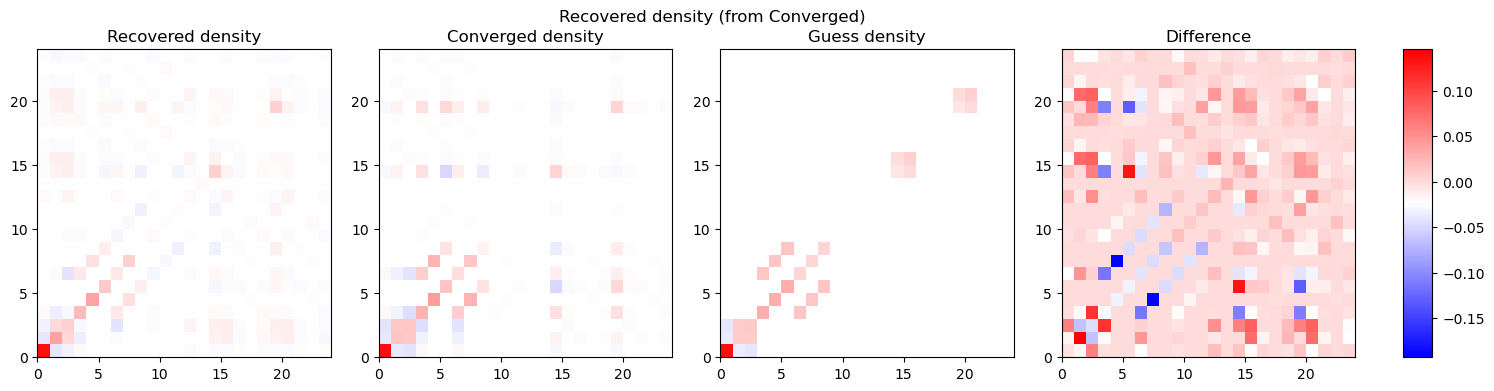

In [ ]:
# try to get C_pq_u back
import numpy as np
# we know V_tu internally from our two basis sets
# we know b_t_pq internally from our two basis sets
#-> This way we can calculate C_pq_u (as done before) and furthermore also invert it:
C_pq_u_inv = np.linalg.pinv(C_pq_u.reshape(-1, C_pq_u.shape[-1]))
D_pq_recov = (C_pq_u_inv.T @ d_u).reshape(D_pq.shape)

from matplotlib.colors import SymLogNorm
log_norm = SymLogNorm(vmin=-10, vmax=10, linthresh=1e-3, linscale=0.3)
# comp D_pq_recov with D_pq
percentage_diff = (D_pq_recov - D_pq) / D_pq

def plotcomp(D_recv, D_ref, D_guess, title):
    fig, ax = plt.subplots(figsize=(18, 4), ncols=5, width_ratios=[1, 1, 1, 1, 0.1])
    ax[0].pcolormesh(D_recv, cmap="bwr", vmin=-1.1, vmax=1.1)
    ax[0].set_title("Recovered density")
    ax[1].pcolormesh(D_ref, cmap="bwr", vmin=-1.1, vmax=1.1)
    ax[1].set_title("Converged density")
    ax[2].pcolormesh(D_guess, cmap="bwr", vmin=-1.1, vmax=1.1)
    ax[2].set_title("Guess density")
    d = ax[3].pcolormesh(D_recv-D_ref, cmap="bwr")
    ax[3].set_title("Difference")
    fig.suptitle(title)
    plt.colorbar(d, cax=ax[4])

plotcomp(D_pq_recov, D_pq, D_guess, "pinv: Recovered density (from Converged)")
total_abs_diff = np.sum(np.abs(D_pq_recov-D_pq))
print(f"Total absolute difference: {total_abs_diff}")

Total absolute difference: 6.291460794135771


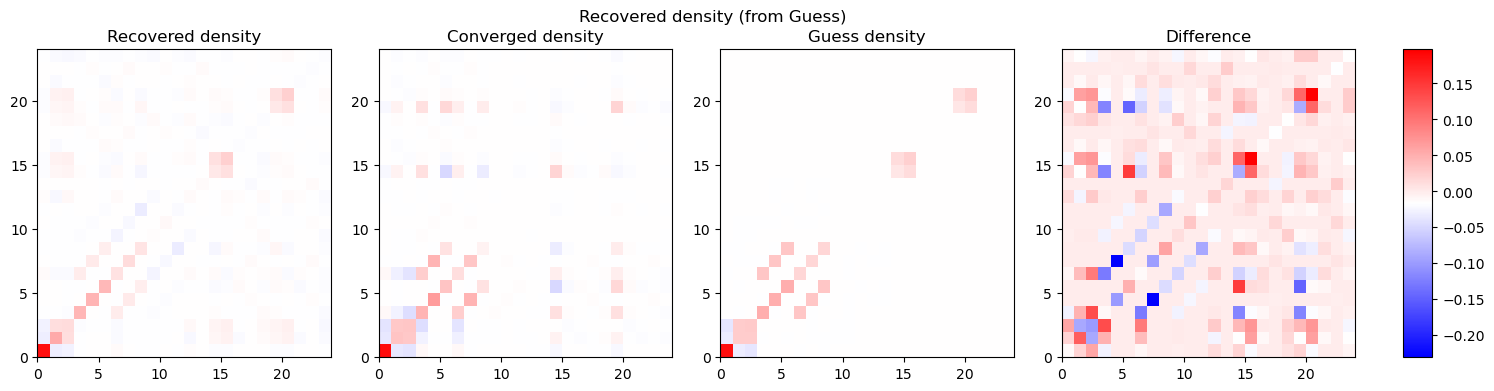

In [ ]:
D_guess_recov = (C_pq_u_inv.T @ d_guess).reshape(D_guess.shape)

plotcomp(D_guess_recov, D_pq, D_guess, "pinv: Recovered density (from Guess)")
total_abs_diff = np.sum(np.abs(D_guess_recov-D_guess))
print(f"Total absolute difference: {total_abs_diff}")

Least square

Total absolute difference: 8.418787368354357
Total absolute difference guess: 6.291460794134782


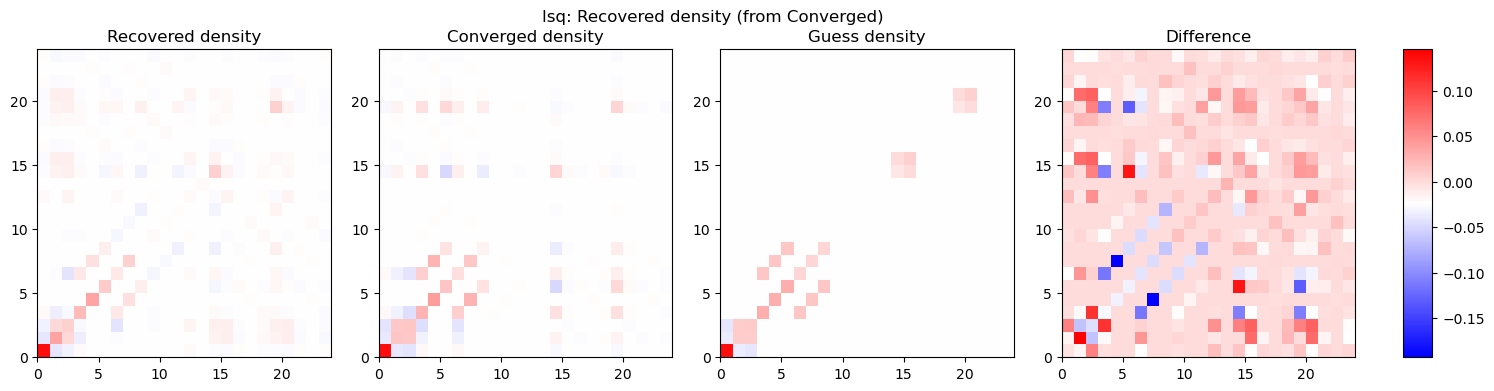

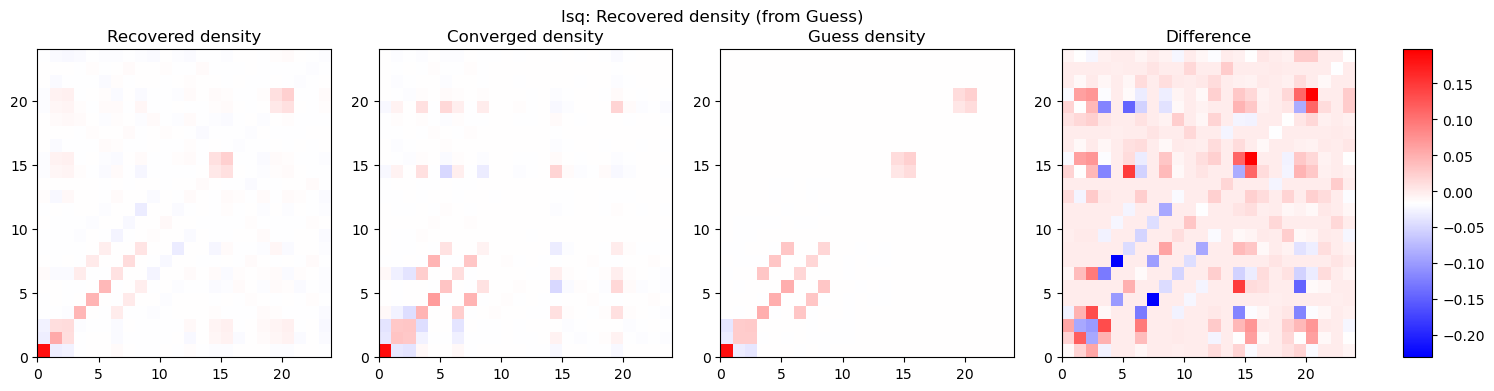

In [154]:
D_pq_recov = np.linalg.lstsq(C_pq_u.reshape(-1, C_pq_u.shape[-1]).T, d_u)
D_pq_recov = D_pq_recov[0].reshape(D_pq.shape) 
D_guess_recov = np.linalg.lstsq(C_pq_u.reshape(-1, C_pq_u.shape[-1]).T, d_guess)
D_guess_recov = D_guess_recov[0].reshape(D_guess.shape)

plotcomp(D_pq_recov, D_pq, D_guess, "lsq: Recovered density (from Converged)")
total_abs_diff = np.sum(np.abs(D_pq_recov-D_guess))
print(f"Total absolute difference: {total_abs_diff}")
plotcomp(D_guess_recov, D_pq, D_guess, "lsq: Recovered density (from Guess)")
total_abs_diff = np.sum(np.abs(D_guess_recov-D_guess))
print(f"Total absolute difference guess: {total_abs_diff}")

solve directly (using compression to square matrix)

In [153]:
def square_reduction(mat): 
    """Reduces matrix to square form (smaller dimension) using SVD"""
    U, S, Vt = np.linalg.svd(mat)
    smallest_dim = min(mat.shape)
    U = U[:smallest_dim, :smallest_dim]
    S_red = np.diag(S[:smallest_dim])
    Vt_red = Vt[:smallest_dim, :smallest_dim]
    return U @ S_red @ Vt_red

C_comp = C_pq_u.reshape(-1, C_pq_u.shape[-1])
C_comp = square_reduction(C_comp)
D_pq_recov = np.linalg.solve(C_comp, d_u)
# D_pq_recov = D_pq_recov.reshape(D_pq.shape)
D_pq_recov.shape


(113,)

In [ ]:
# I do not have a good idea of how to plot these vectors, my first try here is by "shell":
def df_vector_to_matrix(d):
    result = np.empty([df_basis.nshell(), df_basis.max_function_per_shell()])
    result.fill(np.nan)

    for n in range(df_basis.nshell()):
        start_ind = df_basis.shell_to_basis_function(n)
        end_ind = df_basis.shell_to_basis_function(n + 1)
        if end_ind == 0:
            end_ind = df_basis.nbf() + 1
        shell_coefficients = d[start_ind:end_ind]
        result[n, 0 : len(shell_coefficients)] = shell_coefficients
    return result

df_vector_to_matrix(d_u)

array([[ 4.27416716e+00,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [-7.30738749e-03,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [-9.21225606e-02,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [ 2.72793563e-01,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [ 1.80992703e-02,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [ 5.82958206e-01,             nan,             nan,
                    nan,             nan,          

In [ ]:
from matplotlib.cm import seismic
from matplotlib.colors import SymLogNorm

# Create custom cmap than assigns gray values to nan
cmap = seismic
cmap.set_bad("0.7", 1.0)

# Since the vectors are dominated by a few large entries we use
# a log norm for the colorbar
norm = SymLogNorm(vmin=-10, vmax=10, linthresh=1e-3, linscale=0.3)

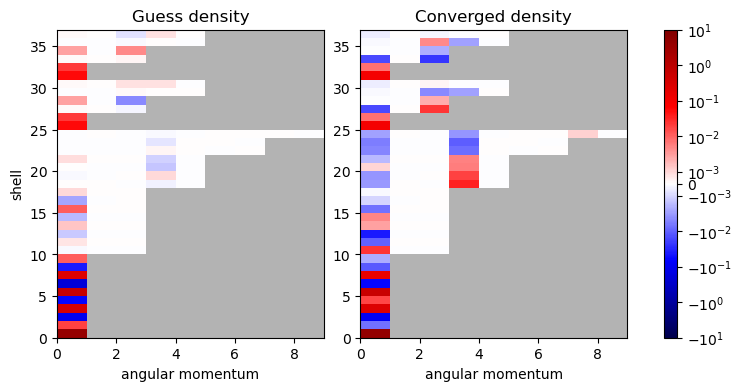

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=3, width_ratios=[1, 1, 0.05])

ax[0].pcolormesh(df_vector_to_matrix(d_guess), cmap=cmap, norm=norm)
ax[0].set_title("Guess density")

p = ax[1].pcolormesh(df_vector_to_matrix(d_u), cmap=cmap, norm=norm)
ax[1].set_title("Converged density")

ax[0].set_xlabel("angular momentum")
ax[1].set_xlabel("angular momentum")
ax[0].set_ylabel("shell")
plt.colorbar(p, cax=ax[2])

In [ ]:
# Lets try another visualization
# def atom_shells()
atom_index_map = {i: f"{mol.symbol(i)}_{i}" for i in range(mol.natom())} # maybe number other way next time 


print(atom_index_map)  # mapping of atom index to atom symbol

indices = {symbol: [] for symbol in atom_index_map.values()}

for n in range(df_basis.nshell()):
    atom_index = df_basis.shell_to_center(n)

    if atom_index != -1:
        indices[atom_index_map[atom_index]].append(n)

# extract coefficients for each atom
def extract_coefficients(d, shell_indices):
    """ Extracts coefficients for given shells """
    coeff_list = []
    
    for n in shell_indices:
        start = df_basis.shell_to_basis_function(n)
        end = start + df_basis.shell_to_basis_function(n + 1)
        coeff_list.append(d[start:end])  # Store as a list of arrays
    
    return coeff_list

{0: 'O_0', 1: 'H_1', 2: 'H_2'}


In [ ]:
import re
def parse_basis_set(basis_set_data):
    """
    Parses the def2-universal-jkfit basis set data to extract shell information.
    
    Parameters:
    - basis_set_data: str, raw text of the basis set file.
    
    Returns:
    - atom_shell_map: dict, maps atom types to their shell angular momenta.
    """
    atom_shell_map = {}
    ang_mom = {"S": 0, "P": 1, "D": 2, "F": 3, "G": 4, "H": 5, "I": 6, "J": 7, "K": 8}
    current_atom = None

    for line in basis_set_data.split("\n"):
        line = line.strip()
        if not line or line.startswith("!") or line.startswith("#"):
            continue

        # Detect new atom block
        match_atom = re.match(r"^[A-Za-z]{1,2}    [SPDFGHIJK]$", line)
        if match_atom:
            current_atom = line.split()[0]
            if current_atom not in atom_shell_map.keys():
                atom_shell_map[current_atom] = []
            atom_shell_map[current_atom] += [ang_mom[line.split()[1]]]
    return atom_shell_map

with open("data/def2-universal-jkfit.1.nw", "r") as f:
    basis_set_data = f.read()
atom_shell_map = parse_basis_set(basis_set_data)

def map_atoms_to_shells_indices(mol, atom_index_map, atom_shell_map, densities=None):
    """
    Maps atoms of mol to their corresponding ang momentum and subsequently shell indices.
    If densities are provided, will return density values instead
    """
    result = {}
    if densities is not None:
        assert True #TODO better assert to check if len(densities) == len(df_basis)
    n_atoms = mol.natom()
    offset = 0
    for i in range(n_atoms):
        pretty_name = atom_index_map[i]
        symbol = pretty_name.split("_")[0]
        shells = atom_shell_map[symbol]
        result[pretty_name] = {}
        el, shells_count = np.unique(np.array(shells), return_counts=True)
        for el, counts in zip(el, shells_count): 
            indices = np.arange(offset, offset + (2 * el + 1) * counts).reshape((2 * el + 1, counts))
            offset += (2 * el + 1) * counts
            if densities is not None:
                indices = np.vectorize(lambda x: densities[x])(indices)
            result[pretty_name][el] = indices
    return result
    
atoms_to_shell_indices = map_atoms_to_shells_indices(mol, atom_index_map, atom_shell_map, d_u)

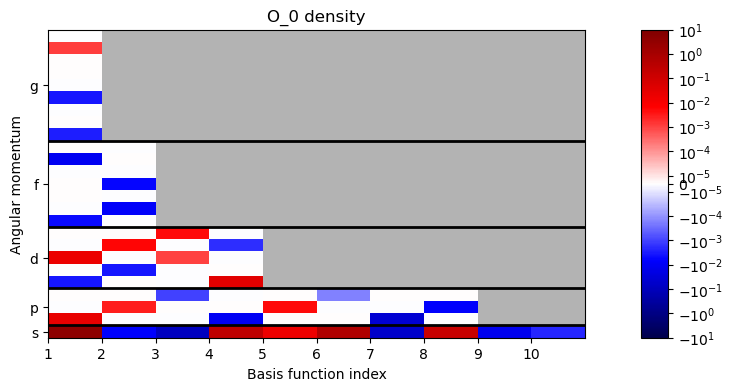

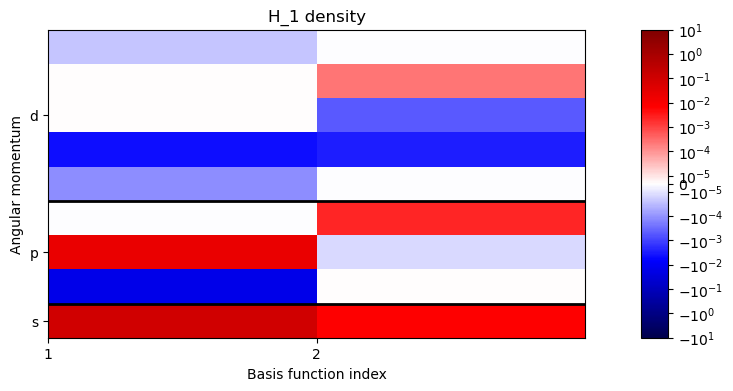

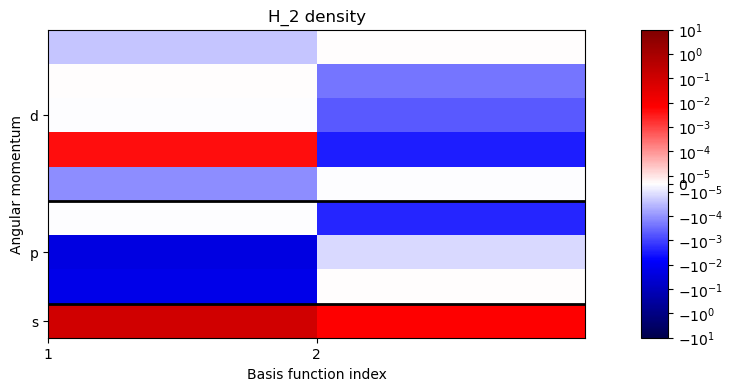

In [ ]:
def pad_and_stack(atom_data, atom_name):
    matrices = list(atom_data[atom_name].values())
    assert all(np.issubdtype(mat.dtype, np.floating) for mat in matrices), "All matrices must be of type float"
    max_width = max(mat.shape[1] for mat in matrices)

    padded_matrices = []
    for mat in matrices: 
        pad_width = max_width - mat.shape[1]
        if pad_width == 0:
            padded_matrices.append(mat)
            continue
        padded_matrices.append(np.pad(mat, ((0, 0), (0, pad_width)), mode="constant", constant_values=np.nan))
    stacked_matrix = np.vstack(padded_matrices)
    return stacked_matrix

def plot_shells(atoms_to_shell_indices, cmap=None, norm=None):
    if not cmap: 
        cmap = seismic
        cmap.set_bad("0.7", 1.0)
    if norm is None:
        norm = SymLogNorm(vmin=-10, vmax=10, linthresh=1e-5, linscale=0.3)
    l_labels = ["s", "p", "d", "f", "g", "h", "i", "j"]
    for atom in atoms_to_shell_indices:
        fig, ax = plt.subplots(figsize=(8, 4), ncols=2, width_ratios=[1, 0.05])
        ax[0].set_title(f"{atom} density")
        sm = pad_and_stack(atoms_to_shell_indices, atom)
        p = ax[0].pcolormesh(sm, cmap=cmap, norm=norm)
        ax[0].set_xlabel("Basis function index")
        ax[0].set_ylabel("Angular momentum")
        ax[0].set_xticks(np.arange(sm.shape[1]))
        ax[0].set_xticklabels(np.arange(1, sm.shape[1] + 1))
        lmax = max(atoms_to_shell_indices[atom].keys())
        l_label_heights = [2 * l + 1 for l in range(lmax + 1)]
        ax[0].set_yticks(np.cumsum(l_label_heights) - np.array(l_label_heights) / 2)
        ax[0].set_yticklabels(l_labels[: len(l_label_heights)])
        y_boundaries = np.cumsum(l_label_heights)[:-1]
        for y in y_boundaries:
            ax[0].hlines(y, xmin=0, xmax=sm.shape[1], colors="black", linewidths=2)
        plt.colorbar(p, cax=ax[1])
        plt.show()

plot_shells(atoms_to_shell_indices)

    